## Learning to Score Behaviors for Guided Policy Optimization

This is a demo for the paper Learning to Score Behaviors for Guided Policy Optimization. In this notebook we introduce our mechanism for calculating the Wasserstein Distance (WD), and apply it to Evolution Strategies (ES) to solve a simple yet deceptively tricky RL environment with our Behavior-Guided Evolution Strategies (BGES) algorithm. 

This is purely illustrative, for reader's convenience, since we introduce quite a few technical concepts and understand it may not be straightforward to grasp.

The code we used for the experiments in the paper was internal and distributed, but this code is designed to run on a single machine in very little time, so we hope that reduces the barrier for people to reproduce/evaluate our method, and hopefully have some fun!

But first, some preliminaries...

In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import simpleenvs # a custom mujoco env we built for this work, more details in the paper.
import seaborn as sns

Now here's the class which computes the Behavioral Test Functions (denoted beta_1 and beta_2). We use random features from [1] which means we do not need to compute the kernel matrix exactly (please see Section 4.2 for a detailed explanation). 

The loss function here is what we use to actually calculate the WD using the latest beta_1 and beta_2. You will see that during the optimization, we first update the behavioral test functions using the new data, then we apply these to evaluate the policies and compute their WDs. But that will come a little later!

In [16]:
class random_wassdist(object):
    def __init__(self, params):
        self.sigma = 1.0
        self.gamma = 1.0
        self.T = 10
        self.n = 1 # num of data points per batch to update kernel function
        self.xdim = params['dim']
        self.alpha = 5e-2
        self.D = params['rf_dim'] # random feature dimension
        self.omega = np.random.randn(self.D, self.xdim) * 1.0 / self.sigma
        self.bias = np.random.rand(self.D, 1) * 2 * np.pi
        self.t = 0

    def get_random_feature(self, x):
        return np.cos(np.dot(self.omega, x) + self.bias) * np.sqrt(2. / self.D)

    def update(self, X, Y, params):
        # sample and update behavioral test functions using single_update
        for _ in range(params['w_iter']):
            x = np.array(X[int(np.random.uniform() * len(X))])
            y = np.array(Y[int(np.random.uniform() * len(X))])
            self.single_update(x, y)

    def single_update(self, x, y):
        if self.t == 0:
            # initialize the functions
            x = np.expand_dims(x, axis=1)
            y = np.expand_dims(y, axis=1)
            self.beta_1 = self.get_random_feature(x).flatten()
            self.beta_2 = self.get_random_feature(y).flatten()
        else:   
            x = np.expand_dims(x, axis=1)
            y = np.expand_dims(y, axis=1)
            
            # map to random feature space
            zx = self.get_random_feature(x)
            zy = self.get_random_feature(y)

            C = np.sum((x-y)**2, axis=0)
            coeff = np.exp((np.dot(self.beta_1, zx) - np.dot(self.beta_2, zy) - C) / self.gamma)
            weight = (1 - coeff)
            weight = np.expand_dims(weight, axis=0)
            
            # update the functions
            self.beta_1 += self.alpha * np.mean(weight * zx, axis=1)
            self.beta_2 += self.alpha * np.mean(weight * zy, axis=1)
        self.t += 1

    def wd(self, x, y):
        x = np.expand_dims(x, axis=1)
        y = np.expand_dims(y, axis=1)
        
        zx = self.get_random_feature(x)
        zy = self.get_random_feature(y)
        wd = np.dot(self.beta_1, zx) - np.dot(self.beta_2, zy) + (1/self.gamma) * np.exp((np.dot(self.beta_1, zx) - np.dot(self.beta_2, zy) - np.sum((x-y)**2))/self.gamma)
        return wd
    

Now we are ready to start talking about reinforcement learning. First up, here's the policy. It is a Toeplitz policy from [2]. This is a compact representation often used for ES methods to reduce the number of parameters. In this case we are running this on a single machine, so it is an effective way to make the code more efficient.

In [17]:
from scipy.linalg import toeplitz

class ToeplitzPolicy(object):
    
    def __init__(self, policy_params):
        
        self.init_seed = policy_params['seed']
        self.ob_dim = policy_params['ob_dim']
        self.h_dim = policy_params['h_dim']
        self.ac_dim = policy_params['ac_dim']
        
        self.w1 = self.weight_init(self.ob_dim + self.h_dim -1, policy_params['zeros'])
        self.w2 = self.weight_init(self.h_dim * 2 - 1, policy_params['zeros'])
        self.w3 = self.weight_init(self.ac_dim + self.h_dim - 1, policy_params['zeros'])
        
        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)
        
        self.b1 = self.weight_init(self.h_dim, policy_params['zeros'])
        self.b2 = self.weight_init(self.h_dim, policy_params['zeros'])
    
        self.params = np.concatenate([self.w1, self.b1, self.w2, self.b2, self.w3])
        self.N = len(self.params)
    
    def weight_init(self, d, zeros):
        if zeros:
            w = np.zeros(d)
        else:
            np.random.seed(self.init_seed)
            w = np.random.rand(d) / np.sqrt(d)
        return(w)
    
    def build_layer(self, d1, d2, v):
        # len v = d1 + d2 - 1
        col = v[:d1]
        row = v[(d1-1):]
        
        W = toeplitz(col, row)
        return(W)
    
    def update(self, vec):
        
        self.params += vec
        
        self.w1 += vec[:len(self.w1)]
        vec = vec[len(self.w1):]
        self.b1 += vec[:len(self.b1)]
        vec = vec[len(self.b1):]
        self.w2 += vec[:len(self.w2)]
        vec = vec[len(self.w2):]
        self.b2 += vec[:len(self.b2)]
        vec = vec[len(self.b2):]
        self.w3 += vec
        
        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)
        
    def evaluate(self, X):        
        z1 = np.tanh(np.dot(self.W1, X) + self.b1)
        z2 = np.tanh(np.dot(self.W2, z1) + self.b2)
        return(np.tanh(np.dot(self.W3, z2)))

Next we can introduce a worker. This is similar to the code from ARS ([4] and here: https://github.com/modestyachts/ARS/blob/master/code/ars.py) so it can work with a library such as ray for parallelization. We do not include this because we have designed our experiment to work on a single machine. That being said, we leave the code in this structure in the hope it should be straightforward to scale up.

In [26]:
class worker(object):
    
    def __init__(self, params, master, A, i, train=True):
        
        self.env = gym.make(params['env_name'])        
        self.v = A[i, :] # the perturbation we will use
        
        params['zeros'] = True # initialize policy with zeros so we can set it to the current policy
        self.policy = ToeplitzPolicy(params)        
        self.policy.update(master.params)
        self.timesteps = 0
            
    def do_rollouts(self, seed=0, train=True):
        
        self.policy.update(self.v) # Add the perturbation, to calculate F(theta + sigma * epsilon)
        up, up_data = self.rollout(seed, train)
        
        self.policy.update(-2 * self.v) # Subtract the perturbation, to calculate F(theta - sigma * epsilon)
        down, down_data = self.rollout(seed, train)
        
        self.rewards = np.reshape(np.array([up, down]), 2)
        self.up_data = up_data # up_data is a list of (state, reward)
        self.down_data = down_data
    
    def rollout(self, seed=0, train=True):
        self.env.seed(0)
        state = self.env.reset()
        self.env._max_episode_steps = 50 # if you want to use another env, then change this!
        total_reward = 0
        done = False
        data = []
        while not done:
            action = self.policy.evaluate(state)
            action = np.random.multivariate_normal(action, 0.01 * np.eye(action.size), 1) # Make the policy nondeterministic
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            data.append([state, reward])
            self.timesteps += 1
        return(total_reward, data)

You'll see that unlike usual rollouts which just return the reward, we also return all of the data from the trajectory. We will apply the Behavioral Embedding Map (BEM) to convert this data into a Probabilistic Policy Embedding (PPE). In this setting, we use the final state as the PPE, but there is potentially a lot of work that can be done on finding optimal PPEs (or learning them). In a larger scale setting you would likely want to compute multiple stochastic trajectories for a more accurate approximation of the WD, but to speed things up we just use one.

In [27]:
def embed(params, data, k=100):
    # For pointenv, they take the state ([0]) at thr last step ([-1]), data is [(state, reward), (state, reward), ...] 
    embedding = data[-1][0][:2] 
    # add alternative PPEs
    return(embedding)

def calcdists(embeddings, dists, i, master, m_embedding, params):
    
    n_master = min(params['n_iter'], params['n_prev'])
    if n_master== 1:
        dists[i, 0] = master.wass.wd(m_embedding[0], embeddings[i])
        dists[i, 1] = master.wass.wd(m_embedding[0], embeddings[i+params['num_sensings']])
    else:
        # if we are comparing vs multiple previous policies
        dists[i, 0] = np.mean([master.wass.wd(x, embeddings[i]) for x in m_embedding])
        dists[i, 1] = np.mean([master.wass.wd(x, embeddings[i+params['num_sensings']]) for x in m_embedding])
    return(dists)


The functions we introduce next are where all the calculations take place, again inspired by ARS [4] (so thanks to them...).

We generate perturbations, perturb the policies (via the worker class) and then evaluate their reward and novelty (measured by WD in the PPE space). The blackbox function, Equation 6 in the paper, is: 

$F(\theta) = \mathcal{L}(\theta) + \beta \mathrm{WD}_\gamma(\mathbb{P}_{\pi_\theta}^\Phi ,\mathbb{P}^{\Phi}_{\mathrm{b}})$

Where $\mathcal{L}(\theta)$ is the cumulative undiscounted reward of the entire rollout.

The gradient of this is calculated below, labelled *. 

In [90]:
def aggregate_rollouts(master, A, params):
       
    all_rollouts = np.zeros([params['num_sensings'], 2])
    up, down = [],[]
    timesteps = 0
    
    # Will generate 50 rollouts
    for i in range(params['num_sensings']):
        w = worker(params, master, A, i)
        w.do_rollouts()
        all_rollouts[i] = w.rewards # w.rewards have up and down rewards
        up.append(embed(params, w.up_data))
#         print('up', embed(params, w.up_data))
        down.append(embed(params, w.down_data))
        timesteps += w.timesteps
    embeddings = up + down
    
    if params['optimizer'] == 'ES':
        dists = np.zeros(params['num_sensings'])
        safety_dists = np.zeros(params['num_sensings'])
    else:
        # Update behavioral test funcs and use them to calculate WDs for each perturbed policy
        if params['n_iter'] == 1:
            dists = np.zeros(params['num_sensings'])
            safety_dists = np.zeros(params['num_sensings'])
        else:
            master.wass.update(master.buffer, embeddings, params)
            
            dists = np.zeros([params['num_sensings'], 2])            
#             for i in range(params['num_sensings']):
#                 # Compute the pairwise WD distances
#                 dists = calcdists(embeddings, dists, i, master, master.embedding, params)
            
            # normalize dists
            dists = (dists - np.mean(dists)) / (np.std(dists)  + 1e-8)
            # They compute the idstances based on -eps samples and +eps samples
            dists = np.array(dists[:, 0] - dists[:, 1])
            
            safety_dists = np.zeros([params['num_sensings'], 2])
            safety_embeddings = params['safety_embeddings']
            for i in range(params['num_sensings']):
                # Compute the pairwise WD distances
                safety_dists = calcdists(embeddings, safety_dists, i, master, safety_embeddings, params)
                        
            safety_dists = (safety_dists - np.mean(safety_dists)) / (np.std(safety_dists)  + 1e-8)
            # They compute the idstances based on -eps samples and +eps samples
            safety_dists = np.array(safety_dists[:, 0] - safety_dists[:, 1])
            
        # Book the latest set of embeddings 
        master.buffer = embeddings
    
    all_rollouts = (all_rollouts - np.mean(all_rollouts)) / (np.std(all_rollouts)  + 1e-8)  
    m = np.array(all_rollouts[:, 0] - all_rollouts[:, 1])
    
    return(m, dists, safety_dists, timesteps)

def ES(params, master):
    
    A = np.random.multivariate_normal(np.zeros(master.N), np.eye(master.N), master.N)
    A *= params['sigma']
    A /= np.linalg.norm(A, axis =-1)[:, np.newaxis]
        
    m, dists, safety_dists, timesteps = aggregate_rollouts(master, A, params)

    g = np.zeros(master.N)
    use_safety_dist = params['use_safety']
    use_repel_dist = params['use_repel']
    for i in range(params['num_sensings']):
        eps = A[i, :]
        # combine reward and WD... beta could be adaptive as in the NSRA algorithm [3]
        if use_safety_dist == True and use_repel_dist == True:
            g += eps * ((1-params['beta'])*m[i] + params['beta']*dists[i] + params['beta']*safety_dists[i]) # *
        elif use_safety_dist == True:
            g += eps * ((1-params['beta'])*m[i] + params['beta']*safety_dists[i]) # *
        elif use_repel_dist == True:
            g += eps * ((1-params['beta'])*m[i] + params['beta']*dists[i]) # *
        else:
            g += eps * (m[i]) # *
    
    g /= (2 * params['sigma'])

    return(g, timesteps)

Below we have the main training procedure to initialize, update and test our agent. 

We include Adam here too.

In [91]:
def Adam(dx, m, v, learning_rate, t, eps = 1e-8, beta1 = 0.9, beta2 = 0.999):
    m = beta1 * m + (1 - beta1) * dx
    mt = m / (1 - beta1 ** t)
    v = beta2 * v + (1-beta2) * (dx **2)
    vt = v / (1 - beta2 ** t)
    update = learning_rate * mt / (np.sqrt(vt) + eps)
    return(update, m, v)

def train(params):
    
    if params['optimizer'] == 'ES':
        params['beta'] = 0 # ie no WD term in the blackbox function F
    else:
        params['beta'] = 0.5 # we use equal weight for the reward and WD. Other schemes could be tested...
    
    env = gym.make(params['env_name'])
    params['ob_dim'] = env.observation_space.shape[0]
    params['ac_dim'] = env.action_space.shape[0]

    m = 0
    v = 0
        
    params['zeros'] = False
    master = ToeplitzPolicy(params)
    # Use the embed dim
    # params['dim'] = params['ob_dim']
    params['dim'] = 2
    master.wass = random_wassdist(params) # initialize the behavioral test functions
    master.buffer = []
    master.embedding = []
    master.history_embeddings = []
        
    n_iter = 1
    ts_cumulative = 0
    ts = []
    rewards = []
    all_weights = pd.DataFrame()
    
    while n_iter < params['max_iter']:
            
        params['n_iter'] = n_iter
        
        # main calculations
        gradient, timesteps = ES(params, master) 
        ts_cumulative += timesteps
        ts.append(ts_cumulative)
        
        # update policy
        gradient /= (np.linalg.norm(gradient) / master.N + 1e-8)
        update, m, v = Adam(gradient, m, v, params['learning_rate'], n_iter)
        master.update(update)
        
        # evaluate new policy, keep the PPE to repel the next iteration
        test_policy = worker(params, master, np.zeros([1, master.N]), 0)
        reward, master_traj = test_policy.rollout()
#         print(reward, embed(params, master_traj),  max(gradient))
        master.embedding.append(embed(params, master_traj))
        master.history_embeddings.append(master.embedding[-1])
        master.embedding = master.embedding[-params['n_prev']:]
        rewards.append(reward)
        
        if n_iter % 10 == 0:
            print('Iteration: %s, Reward: %s' %(n_iter, reward))
        n_iter += 1
        
    df = pd.DataFrame({'Optimizer': [params['optimizer'] for _ in range(len(rewards))], 
                       'Reward': rewards, 
                       'Timesteps': ts,
                       'Embeddings': master.history_embeddings})
    return(df)


We need to specify the parameters for optimization. These are the core parameters that are shared by both ES and BGES. 

In [93]:
params = {}
params['env_name'] = 'point-v0'
params['seed'] = 0 # feel free to change this...
params['max_iter'] = 100 # number of iterations, >100 is usually enough
params['num_sensings'] = 50 # population size
params['safety_embeddings'] = [np.array([(20 + np.random.uniform(low=-1, high=1) * 5), (np.random.uniform(low=-1, high=1) * 5)]) for i in range(5)]
params['learning_rate'] = 0.1 # others should work too
params['sigma'] = 0.1 # scale for the samples
params['h_dim'] = 16 # size of neural network hidden layers
params['rf_dim'] = 1000 # dimensionality of random features, higher = more accurate but slower
params['w_iter'] = 100 # number of samples to update behavioral test funcs
params['n_prev'] = 5 # number of previous policies to compute WD vs current. We have an ablation of this in Fig

<AxesSubplot:>

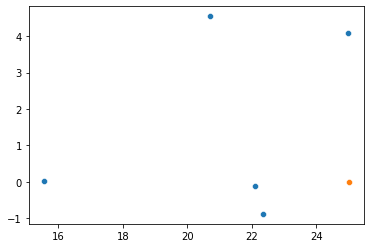

In [94]:
sns.scatterplot(x=[e[0] for e in params['safety_embeddings']], y=[e[1] for e in params['safety_embeddings']])
sns.scatterplot(x=[25,], y=[0,])

We are almost ready to begin optimizing, but first, a brief comment on the environment. This is a custom environment we built to be a low dimensional problem we could use as a testbed. It is included in the paper (Fig 5.).

At every timestep, the agent (a 2-d point) receives a reward linearly related to the distance from a goal. Despite the small size ($|S|=6, |A|=2$) it is non-trivial due to the deceptive barrier. This means that to solve the environment (and ultimately get a higher reward) the agent must not initially go straight, thus, it must initially opt for lower reward behaviors. The idea for this environment came from [3] who used it with a humanoid agent. 

Below we show the initial state of the environment. For 'qualitative' analysis, note that -775 corresponds to moving directly towards the goal and hitting the wall. This number (give or take 1-2) appears a great deal during optimization.

<img src="point_env.png" width="600">





Now we can train some agents! We will do both vanilla ES and BGES. 


In [13]:
print('Safety embeds:', params['safety_embeddings'])
params['optimizer'] = 'BGES'
params['use_safety'] = False
params['use_repel'] = True
df_unsafe_BGES = train(params)

Safety embeds: [array([9.531423  , 1.59073202]), array([9.96206463, 3.39555998]), array([3.97654779, 7.4357982 ]), array([0.55568623, 8.83389448]), array([4.48908456, 4.90276028]), array([3.38331866, 4.64657646]), array([8.58432221, 0.85790116]), array([0.28322279, 3.97348343]), array([7.20018419, 9.8914244 ]), array([10.9605868 ,  7.70814714]), array([11.55540776,  5.54355987]), array([6.23030042, 3.23305642]), array([ 9.26215031, 11.59458257]), array([9.98125751, 5.9321286 ]), array([5.34110838, 4.42234016]), array([2.65012583, 7.49014176]), array([3.9947928 , 6.89483063]), array([10.30771795, 11.93656074]), array([11.72360666,  9.54019825]), array([11.35328283,  0.13929243])]
running build_ext


/home/gridsan/zwhong/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -

[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -

[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -

[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -0.05766308 -0.03045979 -0.09994328]
[-0.08912799  0.09307819  0.02653819 -

<AxesSubplot:xlabel='Embeddings_x', ylabel='Embeddings_y'>

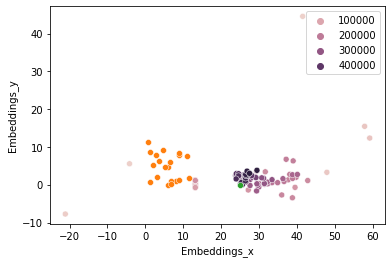

In [228]:
df_unsafe_BGES['Embeddings_x'] = [d[0] for d in df_unsafe_BGES['Embeddings']]
df_unsafe_BGES['Embeddings_y'] = [d[1] for d in df_unsafe_BGES['Embeddings']]
fig, ax = plt.subplots()
sns.scatterplot(x='Embeddings_x', y='Embeddings_y', hue='Timesteps', data=df_unsafe_BGES, ax=ax)
sns.scatterplot(x=[e[0] for e in params['safety_embeddings']], y=[e[1] for e in params['safety_embeddings']])
sns.scatterplot(x=[25,], y=[0,], ax=ax)

In [95]:
print('Safety embeds:', params['safety_embeddings'])
params['optimizer'] = 'BGES'
params['use_safety'] = True
params['use_repel'] = False
df_BGES = train(params)

Safety embeds: [array([22.35299169, -0.87836719]), array([22.09840634, -0.09951938]), array([20.69968388,  4.54605847]), array([15.56312226,  0.02470275]), array([24.98784175,  4.0840572 ])]


/home/gridsan/zwhong/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteration: 10, Reward: -799.5309962290304
Iteration: 20, Reward: -690.0572450510059
Iteration: 30, Reward: -880.8642896282424
Iteration: 40, Reward: -588.2697370225707
Iteration: 50, Reward: -648.9575009851104
Iteration: 60, Reward: -756.6447532267697
Iteration: 70, Reward: -725.53110338336
Iteration: 80, Reward: -718.6794076942572
Iteration: 90, Reward: -1008.7595560745468


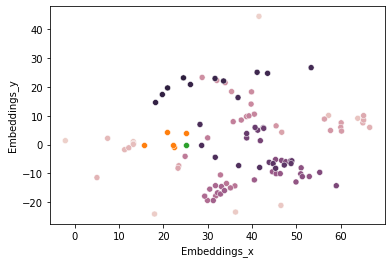

In [101]:
df_BGES['Embeddings_x'] = [d[0] for d in df_BGES['Embeddings']]
df_BGES['Embeddings_y'] = [d[1] for d in df_BGES['Embeddings']]
fig, ax = plt.subplots()
sns.scatterplot(x='Embeddings_x', y='Embeddings_y', hue='Timesteps', data=df_BGES, ax=ax)
sns.scatterplot(x=[e[0] for e in params['safety_embeddings']], y=[e[1] for e in params['safety_embeddings']])
sns.scatterplot(x=[25,], y=[0,], ax=ax)
ax.legend().set_visible(False)

In [97]:
params['optimizer'] = 'ES'
params['use_safety'] = False
params['use_repel'] = False
df_ES = train(params)

/home/gridsan/zwhong/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteration: 10, Reward: -818.4443934681663
Iteration: 20, Reward: -783.4132239394152
Iteration: 30, Reward: -788.36585106423
Iteration: 40, Reward: -779.6995657707866
Iteration: 50, Reward: -779.0855326173156
Iteration: 60, Reward: -779.8122308296121
Iteration: 70, Reward: -776.7149205955495
Iteration: 80, Reward: -778.2185199738444
Iteration: 90, Reward: -777.3749660133498


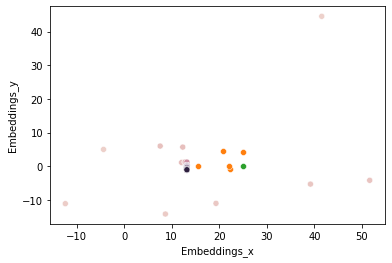

In [102]:
df_ES['Embeddings_x'] = [d[0] for d in df_ES['Embeddings']]
df_ES['Embeddings_y'] = [d[1] for d in df_ES['Embeddings']]
fig, ax = plt.subplots()
sns.scatterplot(x='Embeddings_x', y='Embeddings_y', hue='Timesteps', data=df_ES, ax=ax)
sns.scatterplot(x=[e[0] for e in params['safety_embeddings']], y=[e[1] for e in params['safety_embeddings']])
sns.scatterplot(x=[25,], y=[0,], ax=ax)
ax.legend().set_visible(False)

And last but not least, we can make a simple plot. 

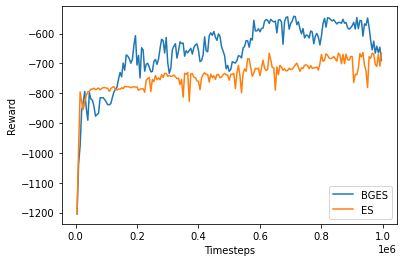

In [131]:
plt.plot(df_BGES.Timesteps, df_BGES.Reward, label='BGES')
plt.plot(df_ES.Timesteps, df_ES.Reward, label='ES')
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.legend(loc="lower right")

As you can see, vanilla ES gets stuck in a local optimum. BGES initially does too, but the behavioral repulsion helps it escape by being 'different' to the previous policies (which were just ending up at the wall). 

Of course, this is just one seed of one environment, but we hope you get the intuition behind the method. We would encourage testing other hyper-parameter settings or other seeds (the seed is most certainly not a hyper-parameter here... almost all should work).

#### Next steps

We would love to discuss potential follow up ideas/collaborations. To get things going, we propose a few:
* Safe RL: We can use trajectories from unsafe or dangerous policies to repel from, eg a car driving dangerously
* Multi-Agent: We can scale this approach to >1 agents, using pairwise WD
* Adaptive $\beta$: We can adapt the amount of emphasis placed on the novelty (WD) term, as in NSRA-ES [3], but in a more rigorous manner

If you want to get in touch, please contact: behaviorguidedRL@gmail.com

Thank you for your time!

#### References

[1] A. Rahimi and B. Recht. Random features for large-scale kernel machines. NeurIPS, 2007.

[2] K. Choromanski, M. Rowland, V. Sindhwani, R. E. Turner, and A. Weller. Structured evolution
with compact architectures for scalable policy optimization. ICML, 2018.

[3] E. Conti, V. Madhavan, F. P. Such, J. Lehman, K. O. Stanley, and J. Clune. Improving exploration in evolution strategies for deep reinforcement learning via a population of novelty-seeking agents. NeurIPS, 2018.

[4] H. Mania, A. Guy, and B. Recht. Simple random search provides a competitive approach to
reinforcement learning. CoRR, 2018.
